In [1]:
import numpy as np
import pandas as pd 
from collections import defaultdict
from pprint import pprint
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
demographic_cols = ['customerID', 'Gender', 'State']

notuse = ['transactionDate']

product_col = ['100105505.0', '108000537.0', '108000568.0', '108000707.0',
       '108001125.0', '108001127.0', '108003448.0', '108003451.0',
       '108004423.0', '108004880.0', '108004977.0', '108005676.0',
       '108005681.0', '108008866.0', '108010225.0', '108015124.0',
       '108015133.0', '108017242.0', '108017245.0', '108018729.0',
       '108018730.0', '108018925.0', '108020429.0', '108030063.0',
       '108030113.0', '108032048.0', '108037499.0', '108037504.0',
       '108037568.0', '108043278.0', '108100137.0', '108100143.0',
       '108100145.0', '108100183.0', '108100193.0', '108100243.0',
       '108100253.0', '108100267.0', '108100278.0', '108100288.0',
       '108100290.0', '108100294.0', '108100296.0', '108100297.0',
       '108100298.0', '108100302.0', '108100306.0', '108100308.0',
       '108100319.0', '108100328.0', '108100330.0', '108100331.0',
       '108100334.0', '108100335.0', '108100340.0', '108100352.0',
       '108100361.0', '108100362.0', '108100382.0', '300028156.0',
       '300070102.0', '300088564.0', '300111517.0', '300143077.0',
       '300144423.0', '300150379.0', '300157247.0', '300177372.0',
       '300317078.0', '300326493.0', '300347917.0', '300361324.0',
       '300374464.0', '300481673.0', '300481740.0', '300481741.0',
       '300497842.0', '300528552.0', '300616595.0', '300647581.0',
       '300676075.0', '300680079.0', '300685217.0', '300776409.0',
       '300776410.0', '300776411.0', '300781593.0', '300785147.0',
       '300785148.0', '300785150.0', '300808923.0', '300840018.0',
       '300942704.0', '300974316.0', '300974360.0', '500096181.0',
       '1000010411.0', '1000058092.0', '1000336252.0', '1000609658.0']

In [3]:
df_train = pd.read_csv('cleaned_data/DataMulticlass_6_withpast2.csv')

In [4]:
df_test = pd.read_csv('cleaned_data/TestSet_withpast3.csv')

In [5]:
pd.set_option('display.max_columns', None)


In [6]:
state_dict = {'MADHY PRADESH':'MADHYA PRADESH', 'TAMILNADU':'TAMIL NADU', 'MADHYA  PRADESH':'MADHYA PRADESH', 'HARAYANA':'HARYANA',
             'Jharkhand':'JHARKHAND','Tamilnadu':'TAMIL NADU','Tamil Nadu':'TAMIL NADU','Madhya Pradesh':'MADHYA PRADESH',
             'REST OF WEST BENGAL':'WEST BENGAL', 'west bengal':'WEST BENGAL','Uttar Pradesh':'UTTAR PRADESH', 'Delhi':'DELHI',
             'Bhopal':'BHOPAL','CHHATISGARH':'CHHATTISGARH','CHATTISGARH':'CHHATTISGARH', 'jharkhand':'JHARKHAND','Chandigarh':'CHANDIGARH',
             'UTTAR PRADESH WEST': 'UTTAR PRADESH','ODISHA':'ORISSA','MAHARASTRA':'MAHARASHTRA','madhya pradesh':'MADHYA PRADESH',
             'KARNATAK':'KARNATAKA','JAMMU and KASHMIR':'JAMMU AND KASHMIR','JAMMU KASHMIR':'JAMMU AND KASHMIR','Rajasthan':'RAJASTHAN',
             'east singhbhum':'JHARKHAND', 'ORRISA':'ORISSA','Andhra Pradesh':'ANDHRA PRADESH', 'UTTARANCHAL':'UTTARAKHAND',
             'Uttar pradesh':'UTTAR PRADESH','Maharashtra':'MAHARASHTRA','MP':'MADHYA PRADESH', 'UTTAR PRADESH EAST':'UTTAR PRADESH',
             'Punjab':'PUNJAB','maharashtra':'MAHARASHTRA','Karnataka':'KARNATAKA','M.P.':'MADHYA PRADESH','DAMAN':'DAMAN AND DIU',
             'HUBLI':'KARNATAKA','Tamil nadu':'TAMIL NADU','GUJRAT':'GUJARAT', 'Mp':'MADHYA PRADESH','Madhya pradesh':'MADHYA PRADESH',
             'West Bengal':'WEST BENGAL','Gujarat':'GUJARAT','UP':'UTTAR PRADESH','Chennai':'CHENNAI', 'm.p.':'MADHYA PRADESH',
             'kerala':'KERALA'}

In [7]:
df_train.replace({"State": state_dict}, inplace=True)

In [8]:
df_test.replace({"State": state_dict}, inplace=True)

In [9]:
df_train['State'].value_counts()

MADHYA PRADESH    1572
no_state          1081
PUNJAB            1047
KARNATAKA          975
JHARKHAND          956
TAMIL NADU         914
ORISSA              83
UTTAR PRADESH       62
GUJARAT             31
DELHI               27
CHHATTISGARH        23
MAHARASHTRA         15
BIHAR                8
WEST BENGAL          5
Name: State, dtype: int64

In [10]:
df_test = df_test[df_test['State'].isin(df_train['State'])]

In [11]:
df_train.head()

,customerID,Gender,State,100105505.0_5,108000537.0_5,108000568.0_5,108000707.0_5,108001125.0_5,108001127.0_5,108003448.0_5,108003451.0_5,108004423.0_5,108004880.0_5,108004977.0_5,108005676.0_5,108005681.0_5,108008866.0_5,108010225.0_5,108015124.0_5,108015133.0_5,108017242.0_5,108017245.0_5,108018729.0_5,108018730.0_5,108018925.0_5,108020429.0_5,108030063.0_5,108030113.0_5,108032048.0_5,108037499.0_5,108037504.0_5,108037568.0_5,108043278.0_5,108100137.0_5,108100143.0_5,108100145.0_5,108100183.0_5,108100193.0_5,108100243.0_5,108100253.0_5,108100267.0_5,108100278.0_5,108100288.0_5,108100290.0_5,108100294.0_5,108100296.0_5,108100297.0_5,108100298.0_5,108100302.0_5,108100306.0_5,108100308.0_5,108100319.0_5,108100328.0_5,108100330.0_5,108100331.0_5,108100334.0_5,108100335.0_5,108100340.0_5,108100352.0_5,108100361.0_5,108100362.0_5,108100382.0_5,300028156.0_5,300070102.0_5,300088564.0_5,300111517.0_5,300143077.0_5,300144423.0_5,300150379.0_5,300157247.0_5,300177372.0_5,300317078.0_5,300326493.0_5,300347917.0_5,300361324.0_5,300374464.0_5,300481673.0_5,300481740.0_5,300481741.0_5,300497842.0_5,300528552.0_5,300616595.0_5,300647581.0_5,300676075.0_5,300680079.0_5,300685217.0_5,300776409.0_5,300776410.0_5,300776411.0_5,300781593.0_5,300785147.0_5,300785148.0_5,300785150.0_5,300808923.0_5,300840018.0_5,300942704.0_5,300974316.0_5,300974360.0_5,500096181.0_5,1000010411.0_5,1000058092.0_5,1000336252.0_5,1000609658.0_5,100105505.0_4,108000537.0_4,108000568.0_4,108000707.0_4,108001125.0_4,108001127.0_4,108003448.0_4,108003451.0_4,108004423.0_4,108004880.0_4,108004977.0_4,108005676.0_4,108005681.0_4,108008866.0_4,108010225.0_4,108015124.0_4,108015133.0_4,108017242.0_4,108017245.0_4,108018729.0_4,108018730.0_4,108018925.0_4,108020429.0_4,108030063.0_4,108030113.0_4,108032048.0_4,108037499.0_4,108037504.0_4,108037568.0_4,108043278.0_4,108100137.0_4,108100143.0_4,108100145.0_4,108100183.0_4,108100193.0_4,108100243.0_4,108100253.0_4,108100267.0_4,108100278.0_4,108100288.0_4,108100290.0_4,108100294.0_4,108100296.0_4,108100297.0_4,108100298.0_4,108100302.0_4,108100306.0_4,108100308.0_4,108100319.0_4,108100328.0_4,108100330.0_4,108100331.0_4,108100334.0_4,108100335.0_4,108100340.0_4,108100352.0_4,108100361.0_4,108100362.0_4,108100382.0_4,300028156.0_4,300070102.0_4,300088564.0_4,300111517.0_4,300143077.0_4,300144423.0_4,300150379.0_4,300157247.0_4,300177372.0_4,300317078.0_4,300326493.0_4,300347917.0_4,300361324.0_4,300374464.0_4,300481673.0_4,300481740.0_4,300481741.0_4,300497842.0_4,300528552.0_4,300616595.0_4,300647581.0_4,300676075.0_4,300680079.0_4,300685217.0_4,300776409.0_4,300776410.0_4,300776411.0_4,300781593.0_4,300785147.0_4,300785148.0_4,300785150.0_4,300808923.0_4,300840018.0_4,300942704.0_4,300974316.0_4,300974360.0_4,500096181.0_4,1000010411.0_4,1000058092.0_4,1000336252.0_4,1000609658.0_4,100105505.0_3,108000537.0_3,108000568.0_3,108000707.0_3,108001125.0_3,108001127.0_3,108003448.0_3,108003451.0_3,108004423.0_3,108004880.0_3,108004977.0_3,108005676.0_3,108005681.0_3,108008866.0_3,108010225.0_3,108015124.0_3,108015133.0_3,108017242.0_3,108017245.0_3,108018729.0_3,108018730.0_3,108018925.0_3,108020429.0_3,108030063.0_3,108030113.0_3,108032048.0_3,108037499.0_3,108037504.0_3,108037568.0_3,108043278.0_3,108100137.0_3,108100143.0_3,108100145.0_3,108100183.0_3,108100193.0_3,108100243.0_3,108100253.0_3,108100267.0_3,108100278.0_3,108100288.0_3,108100290.0_3,108100294.0_3,108100296.0_3,108100297.0_3,108100298.0_3,108100302.0_3,108100306.0_3,108100308.0_3,108100319.0_3,108100328.0_3,108100330.0_3,108100331.0_3,108100334.0_3,108100335.0_3,108100340.0_3,108100352.0_3,108100361.0_3,108100362.0_3,108100382.0_3,300028156.0_3,300070102.0_3,300088564.0_3,300111517.0_3,300143077.0_3,300144423.0_3,300150379.0_3,300157247.0_3,300177372.0_3,300317078.0_3,300326493.0_3,300347917.0_3,300361324.0_3,300374464.0_3,300481673.0_3,300481740.0_3,300481741.0_3,300497842.0_3,300528552.0_3,300616595.0_3,300647581.0_3,300676075.0_3,300680079.0_3,300685217.0_3,30077

In [12]:
# These column are categories feature, I'll transform them using get_dummy
dummy_col = ['Gender','State']
dummy_col_select = ['Gender','State']

In [13]:
limit = int(0.01 * len(df_train.index))
use_dummy_col = {}

for col in dummy_col_select:
    trainlist = df_train[col].value_counts()
    use_dummy_col[col] = []
    for i,item in enumerate(trainlist):
        if item > limit:
            use_dummy_col[col].append(df_train[col].value_counts().index[i])

In [14]:
def get_dummy(df):
    for col in dummy_col_select:
        for item in df[col].unique(): 
            if item not in use_dummy_col[col]:
                row_index = df[col] == item
                df.loc[row_index,col] = np.nan
    return pd.get_dummies(df, prefix=dummy_col, columns = dummy_col)
    
df_train = get_dummy(df_train)
df_test = get_dummy(df_test)

In [15]:
df_train.head()

,customerID,100105505.0_5,108000537.0_5,108000568.0_5,108000707.0_5,108001125.0_5,108001127.0_5,108003448.0_5,108003451.0_5,108004423.0_5,108004880.0_5,108004977.0_5,108005676.0_5,108005681.0_5,108008866.0_5,108010225.0_5,108015124.0_5,108015133.0_5,108017242.0_5,108017245.0_5,108018729.0_5,108018730.0_5,108018925.0_5,108020429.0_5,108030063.0_5,108030113.0_5,108032048.0_5,108037499.0_5,108037504.0_5,108037568.0_5,108043278.0_5,108100137.0_5,108100143.0_5,108100145.0_5,108100183.0_5,108100193.0_5,108100243.0_5,108100253.0_5,108100267.0_5,108100278.0_5,108100288.0_5,108100290.0_5,108100294.0_5,108100296.0_5,108100297.0_5,108100298.0_5,108100302.0_5,108100306.0_5,108100308.0_5,108100319.0_5,108100328.0_5,108100330.0_5,108100331.0_5,108100334.0_5,108100335.0_5,108100340.0_5,108100352.0_5,108100361.0_5,108100362.0_5,108100382.0_5,300028156.0_5,300070102.0_5,300088564.0_5,300111517.0_5,300143077.0_5,300144423.0_5,300150379.0_5,300157247.0_5,300177372.0_5,300317078.0_5,300326493.0_5,300347917.0_5,300361324.0_5,300374464.0_5,300481673.0_5,300481740.0_5,300481741.0_5,300497842.0_5,300528552.0_5,300616595.0_5,300647581.0_5,300676075.0_5,300680079.0_5,300685217.0_5,300776409.0_5,300776410.0_5,300776411.0_5,300781593.0_5,300785147.0_5,300785148.0_5,300785150.0_5,300808923.0_5,300840018.0_5,300942704.0_5,300974316.0_5,300974360.0_5,500096181.0_5,1000010411.0_5,1000058092.0_5,1000336252.0_5,1000609658.0_5,100105505.0_4,108000537.0_4,108000568.0_4,108000707.0_4,108001125.0_4,108001127.0_4,108003448.0_4,108003451.0_4,108004423.0_4,108004880.0_4,108004977.0_4,108005676.0_4,108005681.0_4,108008866.0_4,108010225.0_4,108015124.0_4,108015133.0_4,108017242.0_4,108017245.0_4,108018729.0_4,108018730.0_4,108018925.0_4,108020429.0_4,108030063.0_4,108030113.0_4,108032048.0_4,108037499.0_4,108037504.0_4,108037568.0_4,108043278.0_4,108100137.0_4,108100143.0_4,108100145.0_4,108100183.0_4,108100193.0_4,108100243.0_4,108100253.0_4,108100267.0_4,108100278.0_4,108100288.0_4,108100290.0_4,108100294.0_4,108100296.0_4,108100297.0_4,108100298.0_4,108100302.0_4,108100306.0_4,108100308.0_4,108100319.0_4,108100328.0_4,108100330.0_4,108100331.0_4,108100334.0_4,108100335.0_4,108100340.0_4,108100352.0_4,108100361.0_4,108100362.0_4,108100382.0_4,300028156.0_4,300070102.0_4,300088564.0_4,300111517.0_4,300143077.0_4,300144423.0_4,300150379.0_4,300157247.0_4,300177372.0_4,300317078.0_4,300326493.0_4,300347917.0_4,300361324.0_4,300374464.0_4,300481673.0_4,300481740.0_4,300481741.0_4,300497842.0_4,300528552.0_4,300616595.0_4,300647581.0_4,300676075.0_4,300680079.0_4,300685217.0_4,300776409.0_4,300776410.0_4,300776411.0_4,300781593.0_4,300785147.0_4,300785148.0_4,300785150.0_4,300808923.0_4,300840018.0_4,300942704.0_4,300974316.0_4,300974360.0_4,500096181.0_4,1000010411.0_4,1000058092.0_4,1000336252.0_4,1000609658.0_4,100105505.0_3,108000537.0_3,108000568.0_3,108000707.0_3,108001125.0_3,108001127.0_3,108003448.0_3,108003451.0_3,108004423.0_3,108004880.0_3,108004977.0_3,108005676.0_3,108005681.0_3,108008866.0_3,108010225.0_3,108015124.0_3,108015133.0_3,108017242.0_3,108017245.0_3,108018729.0_3,108018730.0_3,108018925.0_3,108020429.0_3,108030063.0_3,108030113.0_3,108032048.0_3,108037499.0_3,108037504.0_3,108037568.0_3,108043278.0_3,108100137.0_3,108100143.0_3,108100145.0_3,108100183.0_3,108100193.0_3,108100243.0_3,108100253.0_3,108100267.0_3,108100278.0_3,108100288.0_3,108100290.0_3,108100294.0_3,108100296.0_3,108100297.0_3,108100298.0_3,108100302.0_3,108100306.0_3,108100308.0_3,108100319.0_3,108100328.0_3,108100330.0_3,108100331.0_3,108100334.0_3,108100335.0_3,108100340.0_3,108100352.0_3,108100361.0_3,108100362.0_3,108100382.0_3,300028156.0_3,300070102.0_3,300088564.0_3,300111517.0_3,300143077.0_3,300144423.0_3,300150379.0_3,300157247.0_3,300177372.0_3,300317078.0_3,300326493.0_3,300347917.0_3,300361324.0_3,300374464.0_3,300481673.0_3,300481740.0_3,300481741.0_3,300497842.0_3,300528552.0_3,300616595.0_3,300647581.0_3,300676075.0_3,300680079.0_3,300685217.0_3,300776409.0_3,3007

In [16]:
product_col_5 = [col for col in df_train.columns if '.0_5' in col]
product_col_4 = [col for col in df_train.columns if '.0_4' in col]
product_col_3 = [col for col in df_train.columns if '.0_3' in col]
product_col_2 = [col for col in df_train.columns if '.0_2' in col]
product_col_1 = [col for col in df_train.columns if '.0_1' in col]


In [17]:
df_train['tot'] = df_train[product_col_5].sum(axis=1)
df_test['tot'] = df_test[product_col_5].sum(axis=1)

In [18]:
for col in product_col[2:]:
    df_train[col+'_past'] = (df_train[col+'_5']+df_train[col+'_4']+df_train[col+'_3']+df_train[col+'_2']+df_train[col+'_1'])/5
    df_test[col+'_past'] = (df_test[col+'_5']+df_test[col+'_4']+df_test[col+'_3']+df_test[col+'_2']+df_test[col+'_1'])/5

In [19]:
for pro in product_col[2:]:
    df_train[pro+'_past'] = df_train[pro+'_past']*(1-df_train[pro+'_5'])
    df_test[pro+'_past'] = df_test[pro+'_past']*(1-df_test[pro+'_5'])

In [20]:
df_train.head()

,customerID,100105505.0_5,108000537.0_5,108000568.0_5,108000707.0_5,108001125.0_5,108001127.0_5,108003448.0_5,108003451.0_5,108004423.0_5,108004880.0_5,108004977.0_5,108005676.0_5,108005681.0_5,108008866.0_5,108010225.0_5,108015124.0_5,108015133.0_5,108017242.0_5,108017245.0_5,108018729.0_5,108018730.0_5,108018925.0_5,108020429.0_5,108030063.0_5,108030113.0_5,108032048.0_5,108037499.0_5,108037504.0_5,108037568.0_5,108043278.0_5,108100137.0_5,108100143.0_5,108100145.0_5,108100183.0_5,108100193.0_5,108100243.0_5,108100253.0_5,108100267.0_5,108100278.0_5,108100288.0_5,108100290.0_5,108100294.0_5,108100296.0_5,108100297.0_5,108100298.0_5,108100302.0_5,108100306.0_5,108100308.0_5,108100319.0_5,108100328.0_5,108100330.0_5,108100331.0_5,108100334.0_5,108100335.0_5,108100340.0_5,108100352.0_5,108100361.0_5,108100362.0_5,108100382.0_5,300028156.0_5,300070102.0_5,300088564.0_5,300111517.0_5,300143077.0_5,300144423.0_5,300150379.0_5,300157247.0_5,300177372.0_5,300317078.0_5,300326493.0_5,300347917.0_5,300361324.0_5,300374464.0_5,300481673.0_5,300481740.0_5,300481741.0_5,300497842.0_5,300528552.0_5,300616595.0_5,300647581.0_5,300676075.0_5,300680079.0_5,300685217.0_5,300776409.0_5,300776410.0_5,300776411.0_5,300781593.0_5,300785147.0_5,300785148.0_5,300785150.0_5,300808923.0_5,300840018.0_5,300942704.0_5,300974316.0_5,300974360.0_5,500096181.0_5,1000010411.0_5,1000058092.0_5,1000336252.0_5,1000609658.0_5,100105505.0_4,108000537.0_4,108000568.0_4,108000707.0_4,108001125.0_4,108001127.0_4,108003448.0_4,108003451.0_4,108004423.0_4,108004880.0_4,108004977.0_4,108005676.0_4,108005681.0_4,108008866.0_4,108010225.0_4,108015124.0_4,108015133.0_4,108017242.0_4,108017245.0_4,108018729.0_4,108018730.0_4,108018925.0_4,108020429.0_4,108030063.0_4,108030113.0_4,108032048.0_4,108037499.0_4,108037504.0_4,108037568.0_4,108043278.0_4,108100137.0_4,108100143.0_4,108100145.0_4,108100183.0_4,108100193.0_4,108100243.0_4,108100253.0_4,108100267.0_4,108100278.0_4,108100288.0_4,108100290.0_4,108100294.0_4,108100296.0_4,108100297.0_4,108100298.0_4,108100302.0_4,108100306.0_4,108100308.0_4,108100319.0_4,108100328.0_4,108100330.0_4,108100331.0_4,108100334.0_4,108100335.0_4,108100340.0_4,108100352.0_4,108100361.0_4,108100362.0_4,108100382.0_4,300028156.0_4,300070102.0_4,300088564.0_4,300111517.0_4,300143077.0_4,300144423.0_4,300150379.0_4,300157247.0_4,300177372.0_4,300317078.0_4,300326493.0_4,300347917.0_4,300361324.0_4,300374464.0_4,300481673.0_4,300481740.0_4,300481741.0_4,300497842.0_4,300528552.0_4,300616595.0_4,300647581.0_4,300676075.0_4,300680079.0_4,300685217.0_4,300776409.0_4,300776410.0_4,300776411.0_4,300781593.0_4,300785147.0_4,300785148.0_4,300785150.0_4,300808923.0_4,300840018.0_4,300942704.0_4,300974316.0_4,300974360.0_4,500096181.0_4,1000010411.0_4,1000058092.0_4,1000336252.0_4,1000609658.0_4,100105505.0_3,108000537.0_3,108000568.0_3,108000707.0_3,108001125.0_3,108001127.0_3,108003448.0_3,108003451.0_3,108004423.0_3,108004880.0_3,108004977.0_3,108005676.0_3,108005681.0_3,108008866.0_3,108010225.0_3,108015124.0_3,108015133.0_3,108017242.0_3,108017245.0_3,108018729.0_3,108018730.0_3,108018925.0_3,108020429.0_3,108030063.0_3,108030113.0_3,108032048.0_3,108037499.0_3,108037504.0_3,108037568.0_3,108043278.0_3,108100137.0_3,108100143.0_3,108100145.0_3,108100183.0_3,108100193.0_3,108100243.0_3,108100253.0_3,108100267.0_3,108100278.0_3,108100288.0_3,108100290.0_3,108100294.0_3,108100296.0_3,108100297.0_3,108100298.0_3,108100302.0_3,108100306.0_3,108100308.0_3,108100319.0_3,108100328.0_3,108100330.0_3,108100331.0_3,108100334.0_3,108100335.0_3,108100340.0_3,108100352.0_3,108100361.0_3,108100362.0_3,108100382.0_3,300028156.0_3,300070102.0_3,300088564.0_3,300111517.0_3,300143077.0_3,300144423.0_3,300150379.0_3,300157247.0_3,300177372.0_3,300317078.0_3,300326493.0_3,300347917.0_3,300361324.0_3,300374464.0_3,300481673.0_3,300481740.0_3,300481741.0_3,300497842.0_3,300528552.0_3,300616595.0_3,300647581.0_3,300676075.0_3,300680079.0_3,300685217.0_3,300776409.0_3,3007

In [21]:
def runXGB(train_X, train_y, colsample_bytree=0.9, max_depth= 6, eta=0.1, min_child_weight=2, subsample=0.9, num_rounds=150):
    param = {}
    param['objective'] = 'multi:softprob'
    param['seed'] = 0
    param['silent'] = 0
    param['eval_metric'] = "mlogloss"
    param['booster'] = 'gbtree'
    param['num_class'] = 100
    param['reg_lambda'] =100
    param['colsample_bytree'] = colsample_bytree
    param['max_depth'] = max_depth 
    param['eta'] = eta
    param['min_child_weight'] = min_child_weight
    param['subsample'] = subsample
    num_round = num_rounds

    progress = dict()
    plst = list(param.items())
    
    #xgtrain = xgb.DMatrix(train_X.loc[df_train.index.values%10!=0], label=train_y.loc[df_train.index.values%10!=0])
    #xgtest = xgb.DMatrix(train_X.loc[df_train.index.values%10==0], label=train_y.loc[df_train.index.values%10==0])
    #watchlist  = [(xgtrain,'train'),(xgtest,'test')]
    #model = xgb.train(plst, xgtrain, num_rounds,watchlist,evals_result=progress)
    
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    watchlist  = [(xgtrain,'train')]
    model = xgb.train(plst, xgtrain, int(num_rounds/0.9), watchlist, evals_result=progress)
    return (model, progress)

In [22]:
cols = list(df_train.drop(['target','customerID'], 1).columns.values)

id_preds = defaultdict(list)
ids = df_test['customerID'].values

# predict model 
y_train = df_train['target']
x_train = df_train[cols]
    
(clf, progress) = runXGB(x_train, y_train)
          
x_test = df_test[cols]
x_test = x_test.fillna(0) # check this
        
d_test = xgb.DMatrix(x_test)
p_test = clf.predict(d_test)
        
for id, p in zip(ids, p_test):
    #id_preds[id] = list(p)
    id_preds[id] = [0,0] + list(p)

[0]	train-mlogloss:3.89026
[1]	train-mlogloss:3.56474
[2]	train-mlogloss:3.33098
[3]	train-mlogloss:3.14194
[4]	train-mlogloss:2.98716
[5]	train-mlogloss:2.8541
[6]	train-mlogloss:2.73148
[7]	train-mlogloss:2.6219
[8]	train-mlogloss:2.52473
[9]	train-mlogloss:2.4391
[10]	train-mlogloss:2.3615
[11]	train-mlogloss:2.29244
[12]	train-mlogloss:2.22927
[13]	train-mlogloss:2.16695
[14]	train-mlogloss:2.11407
[15]	train-mlogloss:2.06141
[16]	train-mlogloss:2.012
[17]	train-mlogloss:1.96833
[18]	train-mlogloss:1.92677
[19]	train-mlogloss:1.88753
[20]	train-mlogloss:1.85339
[21]	train-mlogloss:1.8178
[22]	train-mlogloss:1.78522
[23]	train-mlogloss:1.75449
[24]	train-mlogloss:1.72788
[25]	train-mlogloss:1.70338
[26]	train-mlogloss:1.67947
[27]	train-mlogloss:1.65763
[28]	train-mlogloss:1.6373
[29]	train-mlogloss:1.6161
[30]	train-mlogloss:1.59469
[31]	train-mlogloss:1.57702
[32]	train-mlogloss:1.55835
[33]	train-mlogloss:1.54151
[34]	train-mlogloss:1.52662
[35]	train-mlogloss:1.51157
[36]	train-

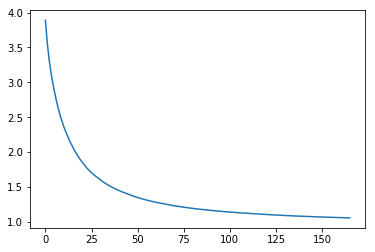

In [24]:
#plt.plot(progress['test']['mlogloss'])
plt.plot(progress['train']['mlogloss'])

In [25]:
sample = pd.read_csv('sampleSubmission.csv')

In [26]:
df = pd.read_csv('all_clean_new.csv')

In [27]:
df.head()

,customerID,Gender,State,transactionDate,target,108000707,108005676,108037568,108100290,108100294,108100306,108100308,108100352,108100362,108100382,300070102,300111517,300481673,300776409,300776410,300776411,300781593,300785148,300785150,300840018
0,BBID_2041,male,no_state,3/20/2016,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BBID_2044,male,no_state,7/28/2015,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,BBID_2044,male,no_state,11/19/2015,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,BBID_2044,male,no_state,8/23/2015,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,BBID_2044,male,no_state,7/28/2015,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [29]:
cols_to_drop = ['Gender', 'State', 'transactionDate', 'target']
df_recent = df.drop(cols_to_drop, axis=1)

In [30]:
df_recent.head()

,customerID,108000707,108005676,108037568,108100290,108100294,108100306,108100308,108100352,108100362,108100382,300070102,300111517,300481673,300776409,300776410,300776411,300781593,300785148,300785150,300840018
0,BBID_2041,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BBID_2044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,BBID_2044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,BBID_2044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,BBID_2044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [47]:
already_active = {}
for row in df_recent.values:
    row = list(row)
    id = row.pop(0)
    active = [c[0] for c in zip(df_recent.columns[1:], row) if c[1] > 0]
    already_active[id] = active

In [48]:
test_preds = {}
for id, p in id_preds.items():
    preds = [i[0] for i in sorted([i for i in zip(df_recent.columns[1:], p) if i[0] not in already_active[id]], key=lambda i:i [1], reverse=True)[:20]]
    test_preds[id] = preds



KeyError: 'BBID_20453293'

In [43]:
test_preds = []
for row in sample.values:
    id = row[0]
    p = train_preds[id]
    test_preds.append(' '.join(p))

KeyError: 'BBID_204221'